(WORK IN PROGRESS)

# Code to Solve the Image Deblurring Problem

## Problem formulation

$\boldsymbol{y} = \boldsymbol{b} \circledast \boldsymbol{x} + \boldsymbol{\varepsilon} , \hspace{2ex} \boldsymbol{\varepsilon} \sim \mathcal{N} (0, \sigma^2 \boldsymbol{I}), \hspace{2ex} \sigma \geq 0.$

- $\boldsymbol{x} \in \mathbb{R}^{n}$: (vectorized) unknown image to recover 
- $\boldsymbol{b} \in \mathbb{R}^{n}$: (vectorized) blurring kernel
- $\boldsymbol{\varepsilon} \in \mathbb{R}^{m}$: noise
- $ \sigma \in \mathbb{R}^+$: noise level 
- $ \boldsymbol{y} \in \mathbb{R}^{n}$: observed measurements
- $ \circledast : \mathbb{R}^{n} \times \mathbb{R}^{n} \mapsto \mathbb{R}^{n}$: denotes cicular convolution (https://en.wikipedia.org/wiki/Convolution)

## Loss function, gradients

### Loss function:

$\ell ({\boldsymbol{x}}) = \frac{1}{2n} \| \boldsymbol{y} - \boldsymbol{b} \circledast \boldsymbol{x} \|_2^2$

### Loss function as a finite sum:

$\ell (\boldsymbol{x}) := \frac{1}{n} \sum_i^n \ell_{i}(\boldsymbol{x}) = \frac{1}{n}\sum_i^n \frac{1}{2}(y_i - \mathcal{C}_i(\boldsymbol{b}) \boldsymbol{x})^2$

- $\mathcal{C}_i(\boldsymbol{b})$ denotes the $i^{\text{th}}$ row of the circulant matrix of $\boldsymbol{x}$

### Full gradient:

$\nabla \ell ({\boldsymbol{x}}) = \frac{1}{n} \boldsymbol{b} \circledast ( \boldsymbol{b} \circledast \boldsymbol{x} - \boldsymbol{y} ) $

### Stochastic gradient:

$\nabla \ell_{i}({\boldsymbol{x}}) = (\boldsymbol{x}^\top \mathcal{C}_i(\boldsymbol{b}) - y_i ) \mathcal{C}_i(\boldsymbol{b})^\top $


In [1]:
from ipynb.fs.full.deblurring_gradients import full_grad, stoch_grad, get_batch

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import dirname, abspath
import os
import matplotlib.pyplot as plt
from PIL import Image
import time

from skimage import data, img_as_float
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio
from skimage.util import random_noise

from scipy.linalg import circulant

In [4]:
np.random.seed(0)

## Set paths
data_path="../data/Set12/"
save_path="./figures/"
blur_path="./motionblur-master/example_kernel/"
image_list = sorted(os.listdir(data_path))
blur_list = sorted(os.listdir(blur_path))

## Read test image
# normalize image pixels in range [0,1]
# orig = np.array(Image.open(data_path + image_list[8])) / 225.0
orig = Image.open(data_path + image_list[8]).resize((128,128))
orig = np.array(orig) / 255.0
mintmp = np.min(orig)
maxtmp = np.max(orig)
orig = (orig - mintmp) / (maxtmp - mintmp)

## Read blurring kernel
blur = Image.open(blur_path + blur_list[2]).resize((128,128))

(-0.5, 127.5, 127.5, -0.5)

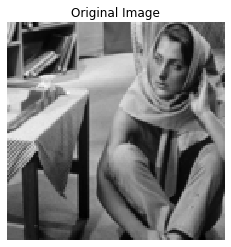

In [5]:
orig_fig = plt.figure()
ax = orig_fig.add_subplot(1, 1, 1)
orig_plot = plt.imshow(orig, cmap='gray', vmin=0, vmax=1)
ax.set_title('Original Image')
ax.axis('off')

(-0.5, 127.5, 127.5, -0.5)

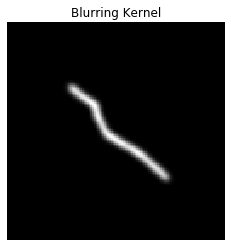

In [6]:
blur_fig = plt.figure()
ax = blur_fig.add_subplot(1, 1, 1)
blur_plot = plt.imshow(blur, cmap='gray')
ax.set_title('Blurring Kernel')
ax.axis('off')

In [7]:
## Set signal model parameters
H, W = orig.shape[:2] 				# height and width of orig image
N = H*W 							# image dimension
sigma = 1							# noise level of measurements

## Vectorize images
vorig = np.matrix.flatten(np.asarray(orig))
vblur = np.matrix.flatten(np.asarray(blur))

## Create noise
noises = np.random.normal(0, sigma, (N,1))

## Create measurements
fblur = np.fft.fft(vblur)
forig = np.fft.fft(vorig)

Y = np.multiply(fblur, forig)
y = np.fft.ifft(Y)
y = y.reshape(N,-1) + noises
y = np.real(np.reshape(y, [H,W]))

## Initialize variables
x_init = np.copy(y)
mintmp = np.min(x_init)
maxtmp = np.max(x_init)
x_init = (x_init - mintmp) / (maxtmp - mintmp)
x = np.copy(x_init)

(-0.5, 127.5, 127.5, -0.5)

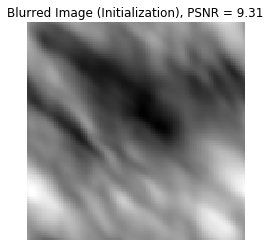

In [8]:
init_fig = plt.figure()
ax = init_fig.add_subplot(1, 1, 1)
init_plot = plt.imshow(x_init, cmap='gray', vmin=0, vmax=1)
ax.set_title(f'Blurred Image (Initialization), PSNR = {peak_signal_noise_ratio(x_init, orig):0.2f}')
ax.axis('off')

In [10]:
## Set parameters
T_outer = 10 				# Number of outer loop iterations
T_inner = 2 				# Number of inner loop iterations
eta_SVRG = .00001 / N				# step size for SVRG
batch_size_SVRG=30000
NLM_filter = .015
patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                multichannel=True)

time_per_iter_SVRG = []
psnr_per_iter_SVRG = []

blur = np.asarray(blur)

t0 = 0
x = np.copy(x_init)
## Main PnP SVRG routine
for i in range(T_outer):
    # outer loop
    mu = full_grad(x, blur, y)   	# Average gradient
    w = np.copy(x) 					# reference point
    start_iter = time.time()
    for j in range(T_inner):
        # inner loop
        ind = get_batch(batch_size_SVRG, H, W, np.transpose(np.nonzero(y))) 	# Get batch index(indices) in terms of (row, col)
        start_grad = time.time()

        v = stoch_grad(x, blur, y, ind) - stoch_grad(w, blur, y, ind) + mu

        x = x - eta_SVRG*v

        # Denoising
        xtilde = np.copy(x)

        # denoise
        x = denoise_nl_means(np.real(xtilde), h=NLM_filter, fast_mode=True, **patch_kw)
        print(str(i) + " " + str(j) + " " + str(peak_signal_noise_ratio(orig, x)))

    stop_iter = time.time()
    time_per_iter_SVRG.append(stop_iter - start_iter)
    psnr_per_iter_SVRG.append(peak_signal_noise_ratio(orig, x))

    t0 += 1
output_SVRG = x


0 0 10.121594419371899
0 1 10.853924262035
1 0 11.499746119957152
1 1 12.059011513694715
2 0 12.534681796679408
2 1 12.933612963832497
3 0 13.264488736145829
3 1 13.536771792280348
4 0 13.758030010921146
4 1 13.935850917119128
5 0 14.078243928407266
5 1 14.191933619639476
6 0 14.28211789647974
6 1 14.353224648895715
7 0 14.409064933801229
7 1 14.452958732545817
8 0 14.487551335597688
8 1 14.515573012353942
9 0 14.540159476309782
9 1 14.561491593922106


In [ ]:
psnr_output_SVRG = peak_signal_noise_ratio(orig, output_SVRG)
svrg_fig = plt.figure()
ax = svrg_fig.add_subplot(1, 1, 1)
svrg_plot = plt.imshow(output_SVRG, cmap='gray', vmin=0, vmax=1)
ax.set_title(f"PnP-SVRG (Ours), PSNR = {psnr_output_SVRG:0.2f}")
ax.axis('off')

In [ ]:
T_GD = 100
eta_GD = .000001 / N
NLM_filter = .001			 		 

patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                multichannel=True)

x = np.copy(x_init)
time_per_iter_GD = []
psnr_per_iter_GD = []

print("Initial PSNR = " + str(peak_signal_noise_ratio(orig, x)))
t1 = 0
# Main PnP GD routine
for i in range(T_GD):
    start_iter = time.time()
    # Update variables
    v = np.real(full_grad(x, blur, y))
    x = x - eta_GD * v

    # Denoising
    xtilde = np.copy(x)

    x = denoise_nl_means(np.real(xtilde), h=NLM_filter, fast_mode=True, **patch_kw)
    stop_iter = time.time()

    time_per_iter_GD.append(stop_iter-start_iter)
    psnr_per_iter_GD.append(peak_signal_noise_ratio(orig, x))

    print(str(i) + " " + str(peak_signal_noise_ratio(orig, x)))
    t1 += 1
output_GD = x

In [ ]:
psnr_output_GD = peak_signal_noise_ratio(orig, output_GD)
gd_fig = plt.figure()
ax = gd_fig.add_subplot(1, 1, 1)
gd_plot = plt.imshow(output_GD, cmap='gray', vmin=0, vmax=1)
ax.set_title(f"PnP-GD, PSNR = {psnr_output_GD:0.2f}")
ax.axis('off')

In [15]:
T_SGD = 10
eta_SGD = .000001/N				# step size for GD
batch_size_SGD = 1000
NLM_filter = .015			 		 

patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                multichannel=True)

x = np.copy(x_init)
time_per_iter_SGD = []
psnr_per_iter_SGD = []

print("Initial PSNR = " + str(peak_signal_noise_ratio(orig, x)))
t2 = 0
# Main PnP SGD routine
for i in range(T_SGD):
    start_iter = time.time()
    # Update variables
    ind = get_batch(batch_size_SVRG, H, W, np.transpose(np.nonzero(y)))

    v = stoch_grad(x, blur, y, ind)
    x = x - eta_SGD * v

    # Denoising
    xtilde = np.copy(x)
    x = denoise_nl_means(np.real(xtilde), h=NLM_filter, fast_mode=True, **patch_kw)
    stop_iter = time.time()
    time_per_iter_SGD.append(stop_iter-start_iter)
    psnr_per_iter_SGD.append(peak_signal_noise_ratio(orig, x))

    print(str(i) + " " + str(peak_signal_noise_ratio(orig, x)))
    t2 += 1
output_SGD = x


Initial PSNR = 9.305484245989103
0 9.391294160422358
1 9.474839204014563
2 9.556498018449727
3 9.636517423753348
4 9.715057854463058
5 9.792410337430754
6 9.868639204708042
7 9.943638523130224
8 10.01738692064932
9 10.089867490834328


In [ ]:
psnr_output_SGD = peak_signal_noise_ratio(orig, output_SGD)
sgd_fig = plt.figure()
ax = sgd_fig.add_subplot(1, 1, 1)
sgd_plot = plt.imshow(output_SGD, cmap='gray', vmin=0, vmax=1)
ax.set_title(f"PnP-SGD, PSNR = {psnr_output_SGD:0.2f}")
ax.axis('off')

In [ ]:
alpha = 2.0
T_ADMM = 20
NLM_filter = .015			 		 

x = np.copy(x_init)
print("Initial PSNR = " + str(peak_signal_noise_ratio(orig, x)))
t3 = 0

patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                multichannel=True)

time_per_iter_ADMM = []
psnr_per_iter_ADMM = []

v = np.copy(x)
u = np.zeros((H,W), dtype=np.float64)

""" Main loop. """
for i in range(T_ADMM):
	start_iter = time.time()
	xold = np.copy(x)
	vold = np.copy(v)
	uold = np.copy(u)
	""" Update variables. """

	vtilde = np.copy(x+u)
	vf = np.fft.fft2(vtilde)
	La2 = 1.0/2.0/alpha
	vf[index] = (La2 * vf[index] + y[index]) / (1.0 + La2)
	v = np.real(np.fft.ifft2(vf))

	""" Denoising step. """

	xtilde = np.copy(2*v - xold - uold)
	mintmp = np.min(xtilde)
	maxtmp = np.max(xtilde)
	xtilde = (xtilde - mintmp) / (maxtmp - mintmp)

	# the reason for the following scaling:
	# our denoisers are trained with "normalized images + noise"
	# so the scale should be 1 + O(sigma)
	scale_range = 1.0 + sigma/255.0/2.0 
	scale_shift = (1 - scale_range) / 2.0
	xtilde = xtilde * scale_range + scale_shift
	

	# pytorch denoising model
	x = denoise_nl_means(np.real(xtilde), h=NLM_filter, fast_mode=True, **patch_kw)

	# scale and shift the denoised image back
	x = (x - scale_shift) / scale_range
	x = x * (maxtmp - mintmp) + mintmp

	""" Update variables. """
	u = uold + xold - v
	stop_iter = time.time()

	time_per_iter_ADMM.append(stop_iter-start_iter)
	psnr_per_iter_ADMM.append(peak_signal_noise_ratio(orig, x))
	print(str(i) + " " + str(peak_signal_noise_ratio(orig, x)))
	t3 += 1

output_ADMM = np.copy(x)

In [ ]:
psnr_output_ADMM = peak_signal_noise_ratio(orig, output_ADMM)
admm_fig = plt.figure()
ax = admm_fig.add_subplot(1, 1, 1)
admm_plot = plt.imshow(output_ADMM, cmap='gray', vmin=0, vmax=1)
ax.set_title(f"PnP-ADMM, PSNR = {psnr_output_ADMM:0.2f}")
ax.axis('off')

In [19]:
T_LSVRG = 10 				# Number of outer loop iterations
eta_LSVRG = .000000001				# step size for SVRG
p = .2						# probability of NOT updating reference point
batch_size_LSVRG=30000
NLM_filter = .015
patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                multichannel=True)

time_per_iter_LSVRG = []
psnr_per_iter_LSVRG = []

x = np.copy(x_init)
w = np.copy(x_init)

t4 = 0
zero_mat = np.zeros([H,W])
# Main PnP SVRG routine
for i in range(T_LSVRG):
    # outer loop
    mu = full_grad(w, blur, y)   	# Average gradient
    # 	w = np.copy(x) 					# reference point
    start_iter = time.time()

    # inner loop
    ind = get_batch(batch_size_SVRG, H, W, np.transpose(np.nonzero(y))) 	# Get batch index(indices) in terms of (row, col)

    start_grad = time.time()
    v = stoch_grad(x, blur, y, ind) - stoch_grad(w, blur, y, ind) + mu
    x = x - eta_LSVRG*v

    # Denoising
    xtilde = np.copy(x)

    # denoise
    x = denoise_nl_means(np.real(xtilde), h=NLM_filter, fast_mode=True, **patch_kw)
    print(str(i) + " " + str(peak_signal_noise_ratio(orig, x)))

    # update reference point with probability 1-p
    if np.random.random() > p:
        w = np.copy(x)
        
    stop_iter = time.time()
    time_per_iter_LSVRG.append(stop_iter - start_iter)
    psnr_per_iter_LSVRG.append(peak_signal_noise_ratio(orig, x))

    t4 += 1
output_LSVRG = x

0 10.651705359423161
1 11.74770531983756
2 12.595945667502955
3 13.224497483861366
4 13.675871787116886
5 13.992155506759458
6 14.210771535904668
7 14.362026978761707
8 14.46738162431502
9 14.5412931300689


In [ ]:
psnr_output_LSVRG = peak_signal_noise_ratio(orig, output_LSVRG)
lsvrg_fig = plt.figure()
ax = lsvrg_fig.add_subplot(1, 1, 1)
lsvrg_plot = plt.imshow(output_LSVRG, cmap='gray', vmin=0, vmax=1)
ax.set_title(f"PnP-L-SVRG, PSNR = {psnr_output_LSVRG:0.2f}")
ax.axis('off')

In [23]:
T_LKatyusha = 10 				# Number of outer loop iterations

p = .02						# probability of NOT updating reference point
theta1 = .0001
theta2 = .0001
eta_LKatyusha = theta2/((1+theta2)*theta1)				# step size for SVRG
mu = 1
L = 1
sigma = mu/L

batch_size_LKatyusha=30000
NLM_filter = .015
patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                multichannel=True)

time_per_iter_LKatyusha = []
psnr_per_iter_LKatyusha = []

y = np.copy(x_init)
w = np.copy(x_init)
z = np.copy(x_init)

t5 = 0
zero_mat = np.zeros([H,W])
# Main PnP SVRG routine
for i in range(T_LKatyusha):
    z_old = np.copy(z)
    x = theta1*z + theta2*w + (1 - theta1 - theta2)*y
    start_iter = time.time()

    # inner loop
    ind = get_batch(batch_size_SVRG, H, W, np.transpose(np.nonzero(y))) 	# Get batch index(indices) in terms of (row, col)

    start_grad = time.time()
    g = stoch_grad(x, blur, y, ind) - stoch_grad(w, blur, y, ind) + full_grad(w, blur, y)
    z = (1 / (1 + eta_LKatyusha*sigma))*(eta_LKatyusha*sigma*x + z - eta_LKatyusha / L * g)
    y = x + theta1*(z - z_old)
    
    # Denoising
    wtilde = np.copy(w)

    # denoise
    w = denoise_nl_means(np.real(wtilde), h=NLM_filter, fast_mode=True, **patch_kw)
    print(str(i) + " " + str(peak_signal_noise_ratio(orig, w)))

    # update reference point with probability 1-p
    if np.random.random() > p:
        w = np.copy(y)
        
    stop_iter = time.time()
    time_per_iter_LKatyusha.append(stop_iter - start_iter)
    psnr_per_iter_LKatyusha.append(peak_signal_noise_ratio(orig, w))

    t5 += 1
output_LKatyusha = w

0 9.311738327052968
1 -79.97575566839788
2 -172.31608077403774
3 -264.7485176800517
4 -357.20819552909904
5 -449.67671329227466
6 -542.1485927134559
7 -634.6220416800187


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.


8 -727.0963757337307
9 -819.5712773830486


In [ ]:
#$ Figure to display iteration count/ clock time vs PSNR for all algorithms
psnr_fig, psnr_ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))

psnr_ax[0].plot(np.cumsum(time_per_iter_SVRG), psnr_per_iter_SVRG)
psnr_ax[0].plot(np.cumsum(time_per_iter_GD), psnr_per_iter_GD)
psnr_ax[0].plot(np.cumsum(time_per_iter_SGD), psnr_per_iter_SGD)
psnr_ax[0].plot(np.cumsum(time_per_iter_ADMM), psnr_per_iter_ADMM)
psnr_ax[0].plot(np.cumsum(time_per_iter_LSVRG), psnr_per_iter_LSVRG)
psnr_ax[0].plot(np.cumsum(time_per_iter_LKatyusha), psnr_per_iter_LKatyusha)

psnr_ax[1].plot(range(t0), psnr_per_iter_SVRG)
psnr_ax[1].plot(range(t1), psnr_per_iter_GD)
psnr_ax[1].plot(range(t2), psnr_per_iter_SGD)
psnr_ax[1].plot(range(t3), psnr_per_iter_ADMM)
psnr_ax[1].plot(range(t4), psnr_per_iter_LSVRG)
psnr_ax[1].plot(range(t5), psnr_per_iter_LKatyusha)

psnr_ax[0].set(xlabel='time (s)', ylabel='PSNR (dB)')
psnr_ax[0].legend(('PnP-SVRG', 'PnP-GD', 'PnP-SGD', 'PnP-ADMM', 'PnP-LSVRG', 'PnP-LKatyusha'), loc='lower right')
psnr_ax[0].grid()

psnr_ax[1].set(xlabel='iteration', ylabel='PSNR (dB)')
psnr_ax[1].legend(('PnP-SVRG','PnP-GD', 'PnP-SGD', 'PnP-ADMM', 'PnP-LSVRG', 'PnP-LKatyusha'), loc='lower right')
psnr_ax[1].grid()

psnr_fig.tight_layout()

plt.show()